In [1]:
import sys
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
import torch.nn.functional as F
import torchvision.utils as vutils
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.utils.data import DataLoader, Dataset
from PIL import Image


from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)
# Re-initialize D, G:
z_dim = 100

criterion = nn.BCELoss()

Device:  cuda


In [2]:
def show_imgs(x, newFig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0, 2).transpose(0, 1)
    if newFig:
        plt.figure()
    plt.imshow(grid.numpy())

In [17]:
# Simple Feedforward Neural Network for Discriminator
class Discriminator(nn.Module):
    def __init__(self, inputDimension=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inputDimension, 128)
        self.nonLin1 = nn.LeakyReLU(0.1)
        self.nonLin2 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), 784)  # flatten
        h1 = self.nonLin1(self.fc1(x))
        h2 = self.nonLin2(h1)
        out = self.fc2(h2)
        out = torch.sigmoid(out)
        return out


class Generator(nn.Module):
    def __init__(self, zDimension=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(zDimension, 128)
        self.nonLin1 = nn.LeakyReLU(0.1)
        self.nonLin1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, x):
        h1 = self.nonLin1(self.fc1(x))
        h2 = self.nonLin1(h1)
        out = self.fc2(h2)
        out = torch.tanh(out)
        out = out.view(x.size(0), 1, 28, 28)
        return out

In [3]:
# DCGAN Architecture for Discriminator and Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input Z: (batch, z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, feature_g * 4, 7, 1, 0),  # (batch, 256, 7, 7)
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                feature_g * 4, feature_g * 2, 4, 2, 1
            ),  # (batch, 128, 14, 14)
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                feature_g * 2, img_channels, 4, 2, 1
            ),  # (batch, 1, 28, 28)
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: (batch, 1, 28, 28)
            nn.Conv2d(img_channels, feature_d, 4, 2, 1),  # (batch, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1),  # (batch, 128, 7, 7)
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, 1, 7, 1, 0),  # (batch, 1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1)

In [5]:
D = Discriminator()
G = Generator()
print(D)
print(G)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1))
    (6): Sigmoid()
  )
)
Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)


In [37]:
samples = torch.randn(5, 1, 28, 28)  # batch size x channels x height x width
D(samples)  # calls the .forward() method implicitly

tensor([[0.4515],
        [0.4637],
        [0.4765],
        [0.6323],
        [0.5146]], grad_fn=<SigmoidBackward0>)


### Things to try:

- What happens if you change the number of samples in a batch?
    - Number of outputs are increased
- What happens if you change the width/height of the input?
    - We run into an error saying that input is not valid. If we generalize the `Discriminator` class, then also we cannot get proper output while adding non-linearty

In [52]:
# print weights from named_parameters
for name, param in D.named_parameters():
    # print(name, param.data)
    print(name, param.size())

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


In [53]:
z = torch.randn(2, 100)  # batch size x z dimension
xGen = G(z)
xGen.shape

torch.Size([2, 1, 28, 28])

In [ ]:
show_imgs(xGen)
show_imgs(z.view(z.size(0), 1, 10, 10))

In [12]:
dataset = torchvision.datasets.FashionMNIST(
    root="./FashionMNIST/",
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    ),
    download=True,
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

torch.Size([1, 28, 28])

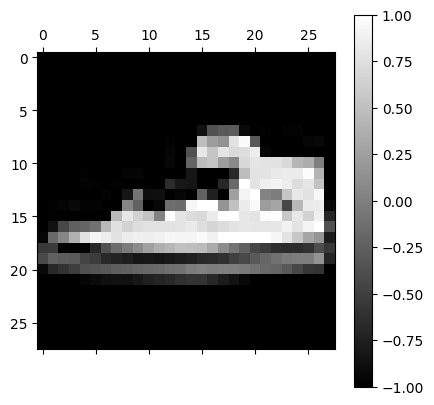

In [16]:
x, _ = dataset[153]
plt.matshow(x.squeeze().numpy(), cmap="gray")
plt.colorbar()
x.shape

In [69]:
Dscore = D(x)
Dscore.item()

0.47513547539711

In [ ]:
xbatch, _ = next(iter(dataloader))
Dscores = D(xbatch)
for image, score in zip(xbatch[:5], Dscores[:5]):
    plt.matshow(image.squeeze().numpy(), cmap="gray")
    plt.colorbar()
    plt.title(f"Score: {score.item():.4f}")

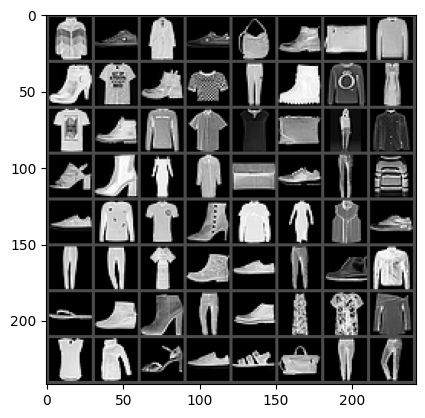

In [76]:
show_imgs(xbatch)

## AutoGrad example

In [91]:
torch.manual_seed(153)
x = torch.rand(2, 2, requires_grad=True)
x

tensor([[0.8112, 0.3310],
        [0.4712, 0.7664]], requires_grad=True)

In [92]:
print(x.grad)  # None

None


In [93]:
y = x**2 + x
z = y.sum()
z

tensor(3.9567, grad_fn=<SumBackward0>)

In [95]:
z.backward()
x.grad

tensor([[2.6223, 1.6621],
        [1.9424, 2.5327]])

In [96]:
2 * x + 1

tensor([[2.6223, 1.6621],
        [1.9424, 2.5327]], grad_fn=<AddBackward0>)

In [99]:
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor([3, 6, 9, -9, -6]).view(5, 1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1)  # 5 x 2 input. 5 datapoints, 2 dimensions.
# theta = torch.randn(1,2, requires_grad=True) # ~equal to:
theta = torch.nn.Parameter(torch.randn(1, 2))
# we start theta at random initialization, the gradient will point us in the right direction.
print("x:\n", x)
print("y:\n", y)
print("theta at random initialization: ", theta)
thetatrace = [theta.data.clone()]  # initial value, for logging

x:
 tensor([[ 1.0000,  1.1894],
        [ 2.0000,  0.2688],
        [ 3.0000, -1.3762],
        [-3.0000,  1.1894],
        [-2.0000,  0.3248]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  Parameter containing:
tensor([[-0.1433, -0.1926]], requires_grad=True)


In [168]:
ypred = x @ theta.t()  # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print("ypred:\n", ypred)
loss = ((ypred - y) ** 2).mean()  # mean squared error = MSE
print("mse loss: ", loss.item())
loss.backward()
print("dL / d theta:\n", theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print("theta:\n", theta)
thetatrace.append(theta.data.clone())  # for logging

ypred:
 tensor([[ 2.9998],
        [ 5.9999],
        [ 9.0001],
        [-9.0000],
        [-6.0000]], grad_fn=<MmBackward0>)
mse loss:  1.1769406782491387e-08
dL / d theta:
 tensor([[-4.5013e-05, -1.6395e-04]])
theta:
 Parameter containing:
tensor([[ 3.0000e+00, -1.1700e-04]], requires_grad=True)


In [169]:
torch.manual_seed(23801)
net = nn.Linear(2, 1, bias=False)
optimizer = torch.optim.SGD(
    net.parameters(), lr=0.1
)  # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100):  # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred - y) ** 2).mean()  # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[ 3.0000e+00, -7.0681e-07]], requires_grad=True)


In [6]:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonLin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonLin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [252]:
# STEP 1: Discriminator optimization step
x_real, _ = next(iter(dataloader))
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100)  # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

print(D_x.mean().item(), D_G_z.mean().item())

0.9761868119239807 0.23800119757652283


In [291]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100)  # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.31000056862831116


Device:  cuda
e0.i0/938 last mb D(x)=0.4527 D(G(z))=0.4166
e0.i100/938 last mb D(x)=0.9880 D(G(z))=0.0006
e0.i200/938 last mb D(x)=0.9805 D(G(z))=0.0003
e0.i300/938 last mb D(x)=0.9982 D(G(z))=0.0026
e0.i400/938 last mb D(x)=0.9920 D(G(z))=0.0087
e0.i500/938 last mb D(x)=0.9986 D(G(z))=0.0010
e0.i600/938 last mb D(x)=0.9949 D(G(z))=0.0010
e0.i700/938 last mb D(x)=0.9963 D(G(z))=0.0000
e0.i800/938 last mb D(x)=0.9996 D(G(z))=0.0007
e0.i900/938 last mb D(x)=0.9991 D(G(z))=0.0005
e1.i0/938 last mb D(x)=0.9997 D(G(z))=0.0004
e1.i100/938 last mb D(x)=0.9998 D(G(z))=0.0004
e1.i200/938 last mb D(x)=0.9999 D(G(z))=0.0003
e1.i300/938 last mb D(x)=0.9999 D(G(z))=0.0008
e1.i400/938 last mb D(x)=0.9999 D(G(z))=0.0002
e1.i500/938 last mb D(x)=0.9999 D(G(z))=0.0001
e1.i600/938 last mb D(x)=0.9997 D(G(z))=0.0001
e1.i700/938 last mb D(x)=0.9996 D(G(z))=0.0001
e1.i800/938 last mb D(x)=1.0000 D(G(z))=0.0001
e1.i900/938 last mb D(x)=1.0000 D(G(z))=0.0001
e2.i0/938 last mb D(x)=0.9999 D(G(z))=0.0001
e2.i1

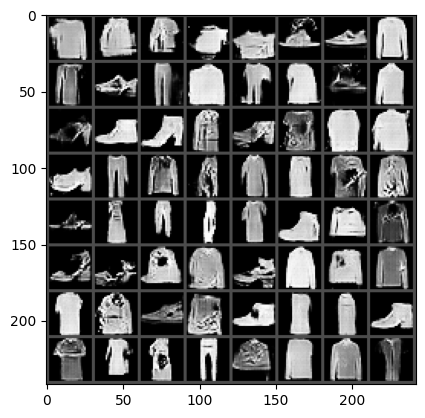

In [ ]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

D = Discriminator().to(device)
G = Generator(z_dim=z_dim).to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
# optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
# optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)

# for plotting
losses_G = []
losses_D = []
scores_real = []
scores_fake = []


# for logging:
collect_x_gen = []
# fixed_noise = torch.randn(64, 100, device=device) # for simple model
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)  # for DCGAN
fig = plt.figure()  # keep updating this one
plt.ion()

for epoch in range(20):  # 3 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = next(iter(dataloader))
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # dynamic labels
        lab_real = torch.ones(batch_size, 1, device=device)
        lab_fake = torch.zeros(batch_size, 1, device=device)

        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        # z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100 for simple model
        z = torch.randn(
            batch_size, z_dim, 1, 1, device=device
        )  # random noise, 64 samples, z_dim=100 for DCGAN
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        # z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100 for simple model
        z = torch.randn(
            batch_size, z_dim, 1, 1, device=device
        )  # random noise, 64 samples, z_dim=100 for DCGAN
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()

        losses_G.append(lossG.item())
        losses_D.append(lossD.item())
        scores_real.append(D_x.mean().item())
        scores_fake.append(D_G_z.mean().item())
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, newFig=False)
            fig.canvas.draw()
            print(
                "e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}".format(
                    epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()
                )
            )
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

In [ ]:
for xGen in collect_x_gen:
    show_imgs(xGen)

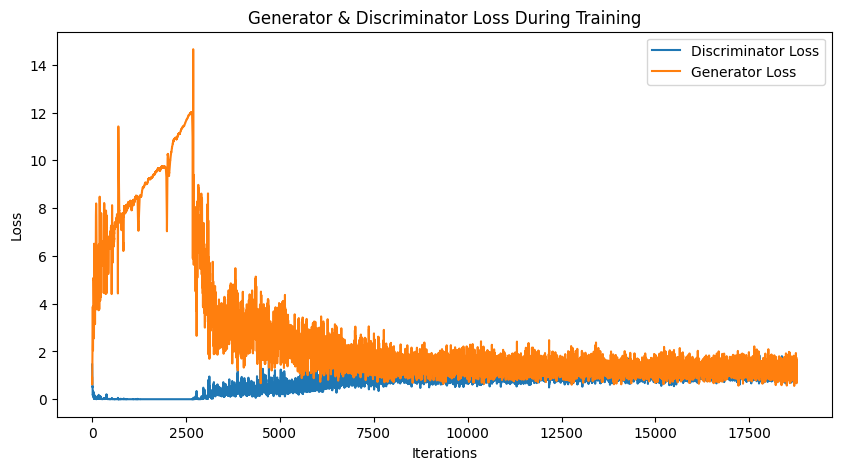

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses_D, label="Discriminator Loss")
plt.plot(losses_G, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator & Discriminator Loss During Training")
plt.show()

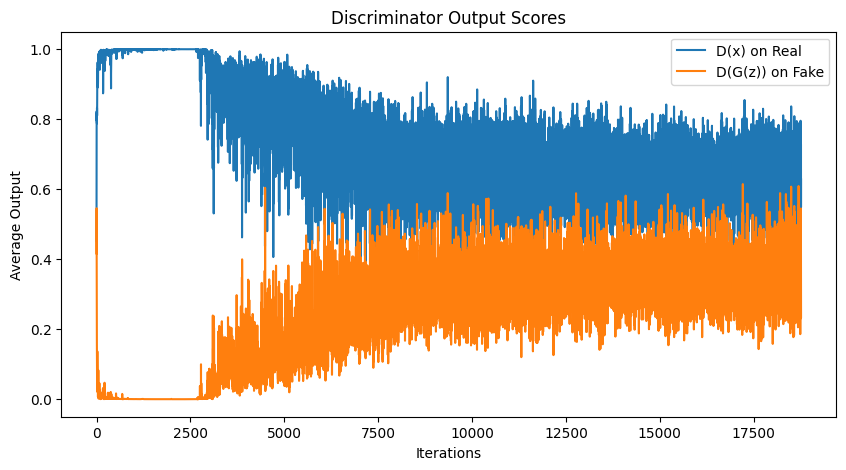

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(scores_real, label="D(x) on Real")
plt.plot(scores_fake, label="D(G(z)) on Fake")
plt.xlabel("Iterations")
plt.ylabel("Average Output")
plt.legend()
plt.title("Discriminator Output Scores")
plt.show()

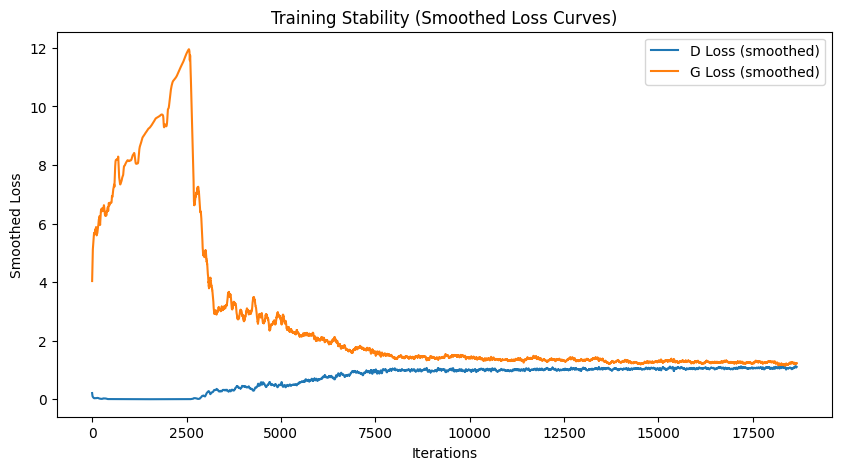

In [ ]:


def moving_average(x, window=100):
    return np.convolve(x, np.ones(window) / window, mode="valid")


plt.figure(figsize=(10, 5))
plt.plot(moving_average(losses_D), label="D Loss (smoothed)")
plt.plot(moving_average(losses_G), label="G Loss (smoothed)")
plt.xlabel("Iterations")
plt.ylabel("Smoothed Loss")
plt.legend()
plt.title("Training Stability (Smoothed Loss Curves)")
plt.show()

In [ ]:
# for MNIST/FashionMNIST
def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    """
    Convert FashionMNIST images from [-1,1], shape (N,1,28,28)
    → uint8 [0,255], shape (N,3,28,28) for FID.
    """
    # From [-1,1] → [0,1]
    imgs = (imgs + 1) / 2.0

    # Scale to [0,255]
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)

    # Repeat grayscale channel to RGB
    imgs = imgs.repeat(1, 3, 1, 1)

    return imgs

In [26]:
fid = FrechetInceptionDistance(feature=2048).to(device)

# Real images
for real_imgs, _ in dataloader:
    real_imgs = real_imgs.to(device)
    real_uint8 = preprocess_for_fid(real_imgs)
    fid.update(real_uint8, real=True)

# Fake images
num_fake = 1000
batch_size = 64
for _ in range(num_fake // batch_size):
    z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    fake_imgs = G(z)
    fake_uint8 = preprocess_for_fid(fake_imgs)
    fid.update(fake_uint8, real=False)

print("FID score:", fid.compute().item())

FID score: 370.184326171875


In [25]:
# create directory if it doesn't exist
directory = "savedModels/DCGAN_KPT_TIPS_RGB"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save checkpoint
torch.save(
    {
        "epoch": epoch,
        "generator_state_dict": G.state_dict(),
        "discriminator_state_dict": D.state_dict(),
        "optimizerG_state_dict": optimizerG.state_dict(),
        "optimizerD_state_dict": optimizerD.state_dict(),
        "lossG": lossG,
        "lossD": lossD,
    },
    f"{directory}/checkpoint[21-40].pth",
)

In [ ]:
# save models
torch.save(G.state_dict(), "savedModels/DCGAN_KPT_TIPS_RGB/generator.pth")
torch.save(D.state_dict(), "savedModels/DCGAN_KPT_TIPS_RGB/discriminator.pth")

In [ ]:
# load models
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)

G.load_state_dict(
    torch.load("savedModels/DCGAN_MNIST/generator.pth", map_location=device)
)
D.load_state_dict(
    torch.load("savedModels/DCGAN_MNIST/discriminator.pth", map_location=device)
)

In [9]:
dataset = torchvision.datasets.ImageFolder(
    root="KTH-TIPS/KTH-TIPS2-b",
    # transform=transforms.Compose(
    #     [
    #         transforms.Resize((200, 200)),
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 3 channels
    #     ]
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((200, 200)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

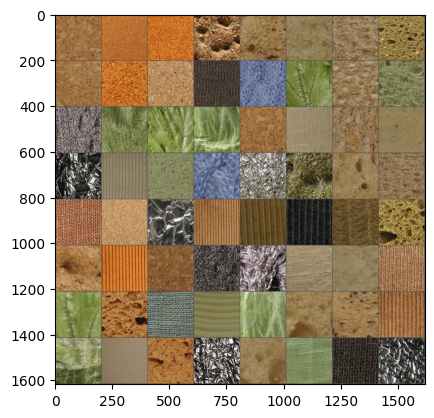

In [8]:
real_imgs, _ = next(iter(dataloader))
show_imgs(real_imgs)

In [10]:
# DCGAN for KTH-TIPS
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_g=64):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            # Input: (B, z_dim, 1, 1)
            nn.ConvTranspose2d(
                in_channels=z_dim,
                out_channels=feature_g * 16,
                kernel_size=5,
                stride=1,
                padding=0,
                bias=False,
            ),  # (B, 1024, 5, 5)
            nn.BatchNorm2d(feature_g * 16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 16,
                out_channels=feature_g * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 512, 10, 10)
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 8,
                out_channels=feature_g * 4,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=False,
            ),  # (B, 256, 25, 25)
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 4,
                out_channels=feature_g * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 128, 50, 50)
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g * 2,
                out_channels=feature_g,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 64, 100, 100)
            nn.BatchNorm2d(feature_g),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=feature_g,
                out_channels=img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # ~ (B, 1, ~200, ~200)
            # <-- Fix to guarantee exact 200x200 output
            nn.Upsample(size=(200, 200), mode="bilinear", align_corners=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.gen(z)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=64):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            # Input: (B, 1, 200, 200)
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),  # (64, 100, 100)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),  # (128, 50, 50)
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                feature_d * 2, feature_d * 4, 4, 2, 1, bias=False
            ),  # (256, 25, 25)
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                feature_d * 4, feature_d * 8, 4, 2, 1, bias=False
            ),  # (512, 12, 12)
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                feature_d * 8, feature_d * 16, 4, 2, 1, bias=False
            ),  # (1024, 6, 6)
            nn.BatchNorm2d(feature_d * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 16, 1, 6, 1, 0, bias=False),  # (1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1)

Loading checkpoint...
Epoch [20/40] Step [0/75] D(x)=0.5469 D(G(z))=0.1744 Loss_D=0.9501 Loss_G=1.6596
Epoch [21/40] Step [0/75] D(x)=0.8786 D(G(z))=0.0773 Loss_D=0.4381 Loss_G=2.5978
Epoch [22/40] Step [0/75] D(x)=0.9507 D(G(z))=0.5290 Loss_D=1.9682 Loss_G=0.6760
Epoch [23/40] Step [0/75] D(x)=0.8731 D(G(z))=0.0226 Loss_D=0.5860 Loss_G=3.6491
Epoch [24/40] Step [0/75] D(x)=0.7997 D(G(z))=0.0981 Loss_D=0.4018 Loss_G=2.3157
FID score at epoch 25: 12.2005
Epoch [25/40] Step [0/75] D(x)=0.6925 D(G(z))=0.1077 Loss_D=0.6116 Loss_G=2.1302
Epoch [26/40] Step [0/75] D(x)=0.6609 D(G(z))=0.0737 Loss_D=0.5755 Loss_G=2.4090
Epoch [27/40] Step [0/75] D(x)=0.9422 D(G(z))=0.4307 Loss_D=1.3114 Loss_G=0.8690
Epoch [28/40] Step [0/75] D(x)=0.8918 D(G(z))=0.0877 Loss_D=0.5275 Loss_G=2.3108
Epoch [29/40] Step [0/75] D(x)=0.9388 D(G(z))=0.5878 Loss_D=1.7280 Loss_G=0.6276
FID score at epoch 30: 10.4587
✅ New best FID 10.4587, checkpoint saved!
Epoch [30/40] Step [0/75] D(x)=0.8675 D(G(z))=0.0783 Loss_D=0.45

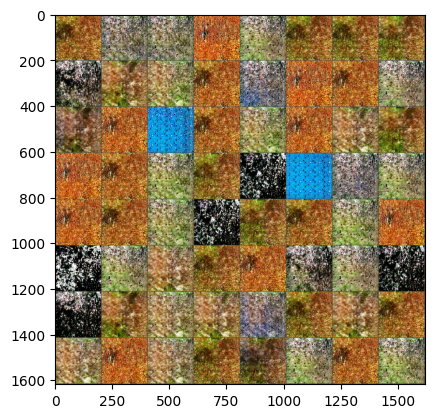

In [ ]:
# training loop
criterion = nn.BCELoss()

D = Discriminator(img_channels=3).to(device)
G = Generator(z_dim=z_dim, img_channels=3).to(device)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias, 0)


G.apply(weights_init)
D.apply(weights_init)

optimizerD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))  # D slower
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

start_epoch = 0
best_fid = float("inf")

if os.path.exists("savedModels/DCGAN_KPT_TIPS_RGB/flipping/checkpoint[0-20].pth"):
    print("Loading checkpoint...")
    checkpoint = torch.load(
        "savedModels/DCGAN_KPT_TIPS_RGB/flipping/checkpoint[0-20].pth",
        map_location=device,
    )
    D.load_state_dict(checkpoint["discriminator_state_dict"])
    G.load_state_dict(checkpoint["generator_state_dict"])
    optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
    optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_fid = checkpoint.get("fid", float("inf"))

end_epoch = start_epoch + 20

# Logging
losses_G, losses_D, scores_real, scores_fake = [], [], [], []
collect_x_gen = []
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

fig = plt.figure()
plt.ion()

# FID setup
fid = FrechetInceptionDistance(feature=2048).to(device)

for epoch in range(start_epoch, end_epoch):
    for i, (x_real, _) in enumerate(dataloader, 0):
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # Labels with smoothing + occasional noisy flips
        lab_real = torch.ones(batch_size, 1, device=device) * 0.9
        lab_fake = torch.zeros(batch_size, 1, device=device)
        if torch.rand(1).item() < 0.05:  # 5% chance to flip
            lab_real, lab_fake = lab_fake, lab_real

        # -------------------------
        # STEP 1: Train Discriminator
        # -------------------------
        optimizerD.zero_grad()

        # Real
        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        # Fake
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        x_gen = G(z).detach()
        D_G_z_fake = D(x_gen)
        lossD_fake = criterion(D_G_z_fake, lab_fake)

        # Total D loss
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # -------------------------
        # STEP 2: Train Generator (multiple steps)
        # -------------------------
        for _ in range(2):  # train G twice per D step
            optimizerG.zero_grad()
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            x_gen = G(z)
            D_G_z = D(x_gen)
            lossG = criterion(D_G_z, lab_real)  # G wants D to output "real"
            lossG.backward()
            optimizerG.step()

        # -------------------------
        # Logging
        # -------------------------
        losses_G.append(lossG.item())
        losses_D.append(lossD.item())
        scores_real.append(D_x.mean().item())
        scores_fake.append(D_G_z.mean().item())

        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, newFig=False)
            fig.canvas.draw()
            print(
                f"Epoch [{epoch}/{start_epoch+20}] Step [{i}/{len(dataloader)}] "
                f"D(x)={D_x.mean().item():.4f} D(G(z))={D_G_z.mean().item():.4f} "
                f"Loss_D={lossD.item():.4f} Loss_G={lossG.item():.4f}"
            )

    # End of epoch snapshot
    with torch.no_grad():
        x_gen = G(fixed_noise)
        collect_x_gen.append(x_gen.detach().clone())

    # -------------------------
    # FID Evaluation every 5 epochs
    # -------------------------
    if (epoch + 1) % 5 == 0:
        fid.reset()

        # Real images
        for real_batch, _ in dataloader:
            real_batch_uint8 = preprocess_for_fid(real_batch.to(device))
            fid.update(real_batch_uint8, real=True)

        # Fake images
        with torch.no_grad():
            for _ in range(len(dataloader)):
                noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
                fake_images = G(noise)
                fake_images_uint8 = preprocess_for_fid(fake_images)
                fid.update(fake_images_uint8, real=False)

        fid_score = fid.compute().item()
        print(f"FID score at epoch {epoch+1}: {fid_score:.4f}")

        # Save best model
        if fid_score < best_fid:
            best_fid = fid_score
            torch.save(
                {
                    "epoch": epoch,
                    "generator_state_dict": G.state_dict(),
                    "discriminator_state_dict": D.state_dict(),
                    "optimizerG_state_dict": optimizerG.state_dict(),
                    "optimizerD_state_dict": optimizerD.state_dict(),
                    "fid": best_fid,
                },
                "savedModels/DCGAN_KPT_TIPS_RGB/best_checkpoint.pth",
            )
            print(f"✅ New best FID {best_fid:.4f}, checkpoint saved!")

        # Save latest checkpoint always
        torch.save(
            {
                "epoch": epoch,
                "generator_state_dict": G.state_dict(),
                "discriminator_state_dict": D.state_dict(),
                "optimizerG_state_dict": optimizerG.state_dict(),
                "optimizerD_state_dict": optimizerD.state_dict(),
                "fid": fid_score,
            },
            "savedModels/DCGAN_KPT_TIPS_RGB/latest_checkpoint.pth",
        )

In [ ]:
for images in collect_x_gen:
    show_imgs(images)

In [ ]:
# for grayscale KTH-TIPS images
def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    """
    Convert KTH-TIPS GAN images from [-1,1], shape (N,1,200,200)
    → uint8 [0,255], shape (N,3,299,299) for FID.
    """
    # [-1,1] → [0,1]
    imgs = (imgs + 1) / 2.0

    # Resize to (299,299) before uint8 conversion
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)

    # Scale to [0,255]
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)

    # Repeat grayscale channel to RGB
    imgs = imgs.repeat(1, 3, 1, 1)

    return imgs

In [28]:
# for RGB KTH-TIPS images
def preprocess_for_fid(imgs: torch.Tensor) -> torch.Tensor:
    """
    Inputs:  GAN outputs or real batches in [-1,1], shape (N,3,200,200)
    Return:  uint8 [0,255], shape (N,3,299,299) for FID (Inception-v3)
    """
    imgs = (imgs + 1) / 2.0  # [-1,1] -> [0,1]
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
    imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)
    return imgs

In [37]:
fid = FrechetInceptionDistance(feature=2048).to(device)
D = Discriminator(img_channels=3).to(device)
G = Generator(z_dim=z_dim, img_channels=3).to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint = torch.load(
    "savedModels/DCGAN_KPT_TIPS_RGB/flipping/checkpoint[21-40].pth", map_location=device
)

D.load_state_dict(checkpoint["discriminator_state_dict"])
G.load_state_dict(checkpoint["generator_state_dict"])
optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])

for real_imgs, _ in dataloader:
    real_imgs = real_imgs.to(device)
    real_uint8 = preprocess_for_fid(real_imgs)
    fid.update(real_uint8, real=True)

for _ in range(len(dataloader)):
    z = torch.randn(64, z_dim, 1, 1, device=device)
    fake_imgs = G(z)
    fake_uint8 = preprocess_for_fid(fake_imgs)
    fid.update(fake_uint8, real=False)
print("FID score:", fid.compute().item())

FID score: 285.73565673828125


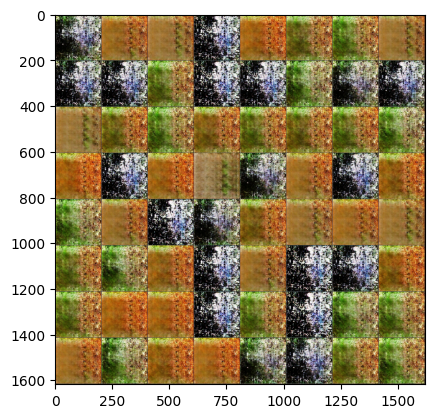

In [18]:
# get generated samples
D = Discriminator(img_channels=3).to(device)
G = Generator(z_dim=z_dim, img_channels=3).to(device)
D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint = torch.load(
    "savedModels/DCGAN_KPT_TIPS_RGB/noFlipping/checkpoint[21-40].pth",
    map_location=device,
)
D.load_state_dict(checkpoint["discriminator_state_dict"])
G.load_state_dict(checkpoint["generator_state_dict"])
D_optimizer.load_state_dict(checkpoint["optimizerD_state_dict"])
G_optimizer.load_state_dict(checkpoint["optimizerG_state_dict"])

z = torch.randn(64, z_dim, 1, 1, device=device)
x_gen = G(z)
show_imgs(x_gen)

## Using Diffusion Models
- They add noise to real image until the image is turned into pure noise and then learn how to generate the real image from that pure noise.
- Training goes something like:
    image + noise --> predict noise --> subtract --> clean image
- They are different from DCGAN because of:
    - Stability (no adversarial loss)
    - provides photorealism is trained for SOTA.

Dataset: FFHQ-256

Model: DDPM (Denoising Diffusion Probabilistic Model)

In [3]:
# U-Net
class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, time_emb_dim, dropout=0.1, num_groups=8
    ):
        super().__init__()
        # Adjust num_groups to avoid errors
        groups = num_groups if out_channels % num_groups == 0 else 1

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
        )

        # for residual connection when in/out channels differ
        self.res_conv = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        # project time embedding and add as bias
        t_out = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)  # (B, C) -> (B,C,1,1)

        h = self.block1(x)
        h = h + t_out
        h = self.block2(h)

        return h + self.res_conv(x)


class UNet(nn.Module):
    def __init__(self, img_channels=3, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.enc1 = ResidualBlock(img_channels, base_channels, time_emb_dim)
        self.enc2 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.enc3 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)

        self.middle = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        self.dec3 = ResidualBlock(
            base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim
        )
        self.dec2 = ResidualBlock(
            base_channels * 2 + base_channels * 2, base_channels, time_emb_dim
        )
        self.dec1 = ResidualBlock(
            base_channels + base_channels, img_channels, time_emb_dim
        )

        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)

        # Encoder
        x1 = self.enc1(x, t)  # (B, 64, 256, 256)
        x2 = self.enc2(self.down(x1), t)  # (B, 128, 128, 128)
        x3 = self.enc3(self.down(x2), t)  # (B, 256, 64, 64)

        # Middle
        m = self.middle(self.down(x3), t)  # (B, 256, 32, 32)

        # Decoder
        d3 = self.up(m)  # (B, 256, 64, 64)
        d3 = self.dec3(torch.cat([d3, x3], dim=1), t)  # concat along channels

        d2 = self.up(d3)  # (B, 128?, 128, 128)
        d2 = self.dec2(torch.cat([d2, x2], dim=1), t)

        d1 = self.up(d2)  # (B, 64?, 256, 256)
        out = self.dec1(torch.cat([d1, x1], dim=1), t)

        return out

In [9]:
# beta schedule & forward/reverse diffusion process
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


timesteps = 100
betas = cosine_beta_schedule(timesteps).to(device)
alphas = (1.0 - betas).to(device)
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0).to(device)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)


def forward_diffusion_sample(x_0, t, device="cuda"):
    noise = torch.randn_like(x_0).to(device)

    # ensure buffers are on the same device as t
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod.to(device)[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.to(device)[
        t
    ].reshape(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [31]:
dataset_path = "FFHQ-256"  # path where your images are stored

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),  # scale to [-1,1]
    ]
)


class FFHQDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.files = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


# Create dataset + dataloader
dataset = FFHQDataset(dataset_path, transform=transform)
dataloader = DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True
)

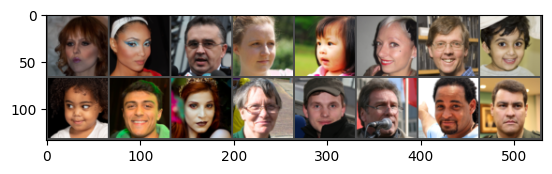

In [16]:
dataiter = iter(dataloader)
images = next(dataiter)
show_imgs(images)

In [ ]:
# training loop
model = UNet(base_channels=32, time_emb_dim=128).to(device)
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
epochs_start = 0
# import from checkpoint if exists
if os.path.exists("savedModels/diffusion_unet_ffhq.pth"):
    print("Loading checkpoint...")
    checkpoint = torch.load(
        "savedModels/diffusion_unet_ffhq[6-10].pth", map_location=device
    )
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    epoch_start = checkpoint["epochs"] + 1

epochs = 50  # realistically 200+ for FFHQ
end_epoch = epochs_start + epochs

for epoch in range(epochs_start, end_epoch):
    for step, x in enumerate(tqdm(dataloader)):
        x = x.to(device)

        # sample random timesteps
        t = torch.randint(0, timesteps, (x.shape[0],), device=device).long()

        # forward diffusion
        x_noisy, noise = forward_diffusion_sample(x, t, device)
        with torch.cuda.amp.autocast('cuda'):
            noise_pred = model(x_noisy, t.unsqueeze(-1).float())
            loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch+1}/{end_epoch}: Loss={loss.item():.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [11:11<00:00,  6.52it/s]


Epoch 1/50: Loss=0.0487


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [08:51<00:00,  8.24it/s]


Epoch 2/50: Loss=0.0236


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [08:19<00:00,  8.75it/s]


Epoch 3/50: Loss=0.0344


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [08:58<00:00,  8.13it/s]


Epoch 4/50: Loss=0.0786


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [05:58<00:00, 12.21it/s]


Epoch 5/50: Loss=0.0273


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [05:48<00:00, 12.55it/s]


Epoch 6/50: Loss=0.0592


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [05:02<00:00, 14.47it/s]


Epoch 7/50: Loss=0.0490


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:23<00:00,  9.86it/s]


Epoch 8/50: Loss=0.0312


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:14<00:00, 10.08it/s]


Epoch 9/50: Loss=0.0268


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:49<00:00, 10.67it/s]


Epoch 10/50: Loss=0.0466


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:44<00:00,  9.41it/s]


Epoch 11/50: Loss=0.0339


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [14:02<00:00,  5.19it/s]


Epoch 12/50: Loss=0.0251


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:38<00:00, 10.99it/s]


Epoch 13/50: Loss=0.0314


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:41<00:00, 10.90it/s]


Epoch 14/50: Loss=0.0194


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:11<00:00, 11.76it/s]


Epoch 15/50: Loss=0.0401


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:26<00:00, 11.32it/s]


Epoch 16/50: Loss=0.0247


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:20<00:00, 11.48it/s]


Epoch 17/50: Loss=0.0203


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:11<00:00, 11.79it/s]


Epoch 18/50: Loss=0.0456


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:21<00:00, 11.46it/s]


Epoch 19/50: Loss=0.0424


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:08<00:00, 11.88it/s]


Epoch 20/50: Loss=0.0305


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:13<00:00, 11.71it/s]


Epoch 21/50: Loss=0.0267


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:19<00:00, 11.54it/s]


Epoch 22/50: Loss=0.0230


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:16<00:00, 11.61it/s]


Epoch 23/50: Loss=0.0204


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:45<00:00, 10.80it/s]


Epoch 24/50: Loss=0.0278


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:25<00:00, 11.34it/s]


Epoch 25/50: Loss=0.0289


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:43<00:00, 10.83it/s]


Epoch 26/50: Loss=0.0237


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:19<00:00, 11.52it/s]


Epoch 27/50: Loss=0.0314


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:35<00:00, 11.08it/s]


Epoch 28/50: Loss=0.0143


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:18<00:00,  9.97it/s]


Epoch 29/50: Loss=0.0454


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [11:33<00:00,  6.31it/s]


Epoch 30/50: Loss=0.0238


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:01<00:00, 10.37it/s]


Epoch 31/50: Loss=0.0265


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:09<00:00, 10.20it/s]


Epoch 32/50: Loss=0.0317


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:00<00:00, 10.39it/s]


Epoch 33/50: Loss=0.0193


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:12<00:00, 10.11it/s]


Epoch 34/50: Loss=0.0226


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:46<00:00, 10.77it/s]


Epoch 35/50: Loss=0.0237


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:50<00:00, 10.66it/s]


Epoch 36/50: Loss=0.0293


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:44<00:00, 10.80it/s]


Epoch 37/50: Loss=0.0249


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:51<00:00, 10.64it/s]


Epoch 38/50: Loss=0.0764


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:56<00:00, 10.51it/s]


Epoch 39/50: Loss=0.0389


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [06:54<00:00, 10.54it/s]


Epoch 40/50: Loss=0.0274


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:06<00:00, 10.25it/s]


Epoch 41/50: Loss=0.0284


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:34<00:00,  9.63it/s]


Epoch 42/50: Loss=0.0351


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:32<00:00,  9.66it/s]


Epoch 43/50: Loss=0.0266


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:10<00:00, 10.17it/s]


Epoch 44/50: Loss=0.0270


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:24<00:00,  9.84it/s]


Epoch 45/50: Loss=0.0166


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:08<00:00, 10.22it/s]


Epoch 46/50: Loss=0.0488


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:27<00:00,  9.79it/s]


Epoch 47/50: Loss=0.0248


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:16<00:00, 10.01it/s]


Epoch 48/50: Loss=0.0247


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:25<00:00,  9.82it/s]


Epoch 49/50: Loss=0.0557


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [07:29<00:00,  9.74it/s]


Epoch 50/50: Loss=0.0436


In [21]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = betas[t].to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
    sqrt_recip_alphas_t = (1.0 / torch.sqrt(alphas[t])).to(device)

    model_mean = sqrt_recip_alphas_t * (
        x
        - betas_t / sqrt_one_minus_alphas_cumprod_t * model(x, t.unsqueeze(-1).float())
    )

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x).to(device)
        return model_mean + torch.sqrt(betas[t]) * noise


@torch.no_grad()
def sample_images(model, img_size=64, n=16, timesteps=100):
    model.eval()
    x = torch.randn(n, 3, img_size, img_size, device=device)  # start from noise

    for t in tqdm(reversed(range(timesteps)), desc="Sampling"):
        t_tensor = torch.full((n, 1), t, device=device).float()
        noise_pred = model(x, t_tensor)

        # Ensure tensor indexing
        alpha = alphas_cumprod[t].to(device)
        alpha_prev = (
            alphas_cumprod[t - 1].to(device)
            if t > 0
            else torch.tensor(1.0, device=device)
        )
        beta = 1 - alpha / alpha_prev

        # broadcast scalars correctly
        alpha = alpha.reshape(1, 1, 1, 1)
        alpha_prev = alpha_prev.reshape(1, 1, 1, 1)
        beta = beta.reshape(1, 1, 1, 1)

        x = (x - beta * noise_pred) / torch.sqrt(alpha)
        if t > 0:
            x += torch.sqrt(beta) * torch.randn_like(x)

    x = (x.clamp(-1, 1) + 1) / 2  # back to [0,1]
    return x

In [33]:
# save model checkpoint
checkpoint_path = "savedModels/diffusion_unet_ffhq[50].pth"
checkpoint = {
    "epochs": end_epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scaler_state_dict": scaler.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

Sampling: 100it [00:00, 112.54it/s]


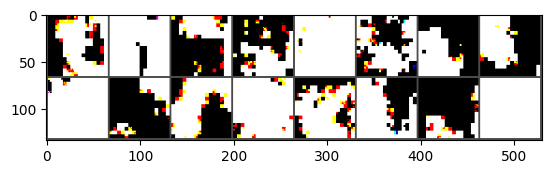

In [34]:
# importing model checkpoint
model = UNet(base_channels=32, time_emb_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()

checkpoint = torch.load("savedModels/diffusion_unet_ffhq[50].pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scaler.load_state_dict(checkpoint["scaler_state_dict"])

samples = sample_images(model, img_size=64, n=16, timesteps=100)
show_imgs(samples)

### DCGAN on FFHQ-256

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 200      # Resize input images
batch_size = 12
z_dim = 100
num_epochs_block = 20   # train in blocks of 20 epochs
checkpoint_dir = "savedModels/DCGAN_FFHQ_256/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs("Images/DCGAN_FFHQ_256", exist_ok=True)

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(3)], [0.5 for _ in range(3)]) # 3-channel normalize
])

dataset = datasets.ImageFolder(root="ffhq256", transform=transform)

if len(dataset) < 200:
    raise ValueError(f"Dataset too small: {len(dataset)} images found, need at least 200.")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [6]:
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
scaler = torch.cuda.amp.GradScaler()
fixed_noise = torch.randn(16, z_dim, 1, 1, device=device)


C:\Users\Jay\AppData\Local\Temp\ipykernel_17132\139359032.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [7]:
def train_dcgan(start_epoch=0, resume=False):
    if resume and start_epoch > 0:
        # Load from the previous epoch (start_epoch-1)
        g_path = f"{checkpoint_dir}/G_epoch{start_epoch-1}.pth"
        d_path = f"{checkpoint_dir}/D_epoch{start_epoch-1}.pth"
        if os.path.exists(g_path) and os.path.exists(d_path):
            G.load_state_dict(torch.load(g_path, map_location=device))
            D.load_state_dict(torch.load(d_path, map_location=device))
            print(f"✅ Resumed from checkpoints at epoch {start_epoch-1}, continuing from {start_epoch}")
        else:
            print(f"⚠️ No checkpoint found for epoch {start_epoch-1}, training from scratch instead.")

    print(f"\nTraining starts at epoch {start_epoch} for {num_epochs_block} epochs...")
    start_time = time.time()

    for epoch in range(start_epoch, start_epoch + num_epochs_block):
        for i, (real, _) in enumerate(dataloader):
            b_size = real.size(0)
            real = real.to(device, non_blocking=True)
            noise = torch.randn(b_size, z_dim, 1, 1, device=device)

            # ========================
            # Train Discriminator
            # ========================
            with torch.cuda.amp.autocast():
                fake = G(noise)
                label_real = torch.empty_like(D(real)).uniform_(0.9, 1.0)
                label_fake = torch.empty_like(D(fake.detach())).uniform_(0.0, 0.1)
                D_real = D(real)
                D_fake = D(fake.detach())
                lossD = (criterion(D_real, label_real) + criterion(D_fake, label_fake)) / 2

            optimizerD.zero_grad()
            scaler.scale(lossD).backward()
            scaler.step(optimizerD)

            # ========================
            # Train Generator
            # ========================
            with torch.cuda.amp.autocast():
                D_fake_for_G = D(fake)
                lossG = criterion(D_fake_for_G, torch.ones_like(D_fake_for_G))

            optimizerG.zero_grad()
            scaler.scale(lossG).backward()
            scaler.step(optimizerG)
            scaler.update()

            if i % 100 == 0:
                print(f"Epoch [{epoch}] Batch {i}/{len(dataloader)} | D Loss: {lossD.item():.4f}, G Loss: {lossG.item():.4f}")

        # Save after every epoch
        with torch.no_grad():
            fake_samples = G(fixed_noise).detach().cpu()
            save_image(fake_samples, f"Images/DCGAN_FFHQ_256/epoch{epoch}.png", nrow=4, normalize=True)
            torch.save(G.state_dict(), f"{checkpoint_dir}/G_epoch{epoch}.pth")
            torch.save(D.state_dict(), f"{checkpoint_dir}/D_epoch{epoch}.pth")
            print(f"Saved checkpoint at epoch {epoch}")

    # Show estimated time
    elapsed = time.time() - start_time
    print(f"\n Block of {num_epochs_block} epochs completed in {elapsed/60:.2f} minutes.")

In [ ]:
# First block (0 → 20)
train_dcgan(start_epoch=0, resume=False)


Training starts at epoch 0 for 20 epochs...


C:\Users\Jay\AppData\Local\Temp\ipykernel_603296\119296138.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Jay\AppData\Local\Temp\ipykernel_603296\119296138.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [0] Batch 0/5834 | D Loss: 0.6653, G Loss: 3.1981
Epoch [0] Batch 100/5834 | D Loss: 0.2665, G Loss: 4.9033
Epoch [0] Batch 200/5834 | D Loss: 0.1831, G Loss: 3.1158
Epoch [0] Batch 300/5834 | D Loss: 0.2177, G Loss: 4.1794
Epoch [0] Batch 400/5834 | D Loss: 0.2107, G Loss: 3.4947
Epoch [0] Batch 500/5834 | D Loss: 0.2309, G Loss: 2.8428
Epoch [0] Batch 600/5834 | D Loss: 0.1900, G Loss: 3.2060
Epoch [0] Batch 700/5834 | D Loss: 0.1957, G Loss: 2.7885
Epoch [0] Batch 800/5834 | D Loss: 0.2017, G Loss: 3.2368
Epoch [0] Batch 900/5834 | D Loss: 0.1926, G Loss: 3.0817
Epoch [0] Batch 1000/5834 | D Loss: 0.1962, G Loss: 2.9657
Epoch [0] Batch 1100/5834 | D Loss: 0.1813, G Loss: 3.3522
Epoch [0] Batch 1200/5834 | D Loss: 0.1886, G Loss: 3.3846
Epoch [0] Batch 1300/5834 | D Loss: 0.1714, G Loss: 3.6083
Epoch [0] Batch 1400/5834 | D Loss: 0.1846, G Loss: 3.2907
Epoch [0] Batch 1500/5834 | D Loss: 0.1719, G Loss: 3.5704
Epoch [0] Batch 1600/5834 | D Loss: 0.2061, G Loss: 2.9407
Epoch [0]

In [ ]:
# Resume next block (20 → 40)
train_dcgan(start_epoch=20, resume=True)

✅ Resumed from checkpoints at epoch 19, continuing from 20

Training starts at epoch 20 for 20 epochs...


C:\Users\Jay\AppData\Local\Temp\ipykernel_16316\789854063.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Jay\AppData\Local\Temp\ipykernel_16316\789854063.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [20] Batch 0/5834 | D Loss: 0.1963, G Loss: 3.1194
Epoch [20] Batch 100/5834 | D Loss: 0.1798, G Loss: 3.0097
Epoch [20] Batch 200/5834 | D Loss: 0.2120, G Loss: 2.9658
Epoch [20] Batch 300/5834 | D Loss: 0.2068, G Loss: 2.9664
Epoch [20] Batch 400/5834 | D Loss: 0.2000, G Loss: 2.9638
Epoch [20] Batch 500/5834 | D Loss: 0.2142, G Loss: 2.9630
Epoch [20] Batch 600/5834 | D Loss: 0.1876, G Loss: 2.9825
Epoch [20] Batch 700/5834 | D Loss: 0.1791, G Loss: 3.0351
Epoch [20] Batch 800/5834 | D Loss: 0.2090, G Loss: 2.9901
Epoch [20] Batch 900/5834 | D Loss: 0.1960, G Loss: 3.0627
Epoch [20] Batch 1000/5834 | D Loss: 0.1933, G Loss: 2.9969
Epoch [20] Batch 1100/5834 | D Loss: 0.2106, G Loss: 3.0195
Epoch [20] Batch 1200/5834 | D Loss: 0.1952, G Loss: 3.0616
Epoch [20] Batch 1300/5834 | D Loss: 0.1981, G Loss: 2.9847
Epoch [20] Batch 1400/5834 | D Loss: 0.2125, G Loss: 3.0068
Epoch [20] Batch 1500/5834 | D Loss: 0.2014, G Loss: 2.9624
Epoch [20] Batch 1600/5834 | D Loss: 0.1876, G Loss:

In [8]:
# Resume next block (40 → 60)
train_dcgan(start_epoch=40, resume=True)

✅ Resumed from checkpoints at epoch 39, continuing from 40

Training starts at epoch 40 for 20 epochs...


C:\Users\Jay\AppData\Local\Temp\ipykernel_17132\2118129851.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Jay\AppData\Local\Temp\ipykernel_17132\2118129851.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [40] Batch 0/5834 | D Loss: 0.2037, G Loss: 2.9820
Epoch [40] Batch 100/5834 | D Loss: 0.2128, G Loss: 2.9163
Epoch [40] Batch 200/5834 | D Loss: 0.1945, G Loss: 3.0065
Epoch [40] Batch 300/5834 | D Loss: 0.2042, G Loss: 2.9990
Epoch [40] Batch 400/5834 | D Loss: 0.2014, G Loss: 3.0494
Epoch [40] Batch 500/5834 | D Loss: 0.1928, G Loss: 2.9471
Epoch [40] Batch 600/5834 | D Loss: 0.2061, G Loss: 3.0300
Epoch [40] Batch 700/5834 | D Loss: 0.1930, G Loss: 3.0531
Epoch [40] Batch 800/5834 | D Loss: 0.2053, G Loss: 2.9040
Epoch [40] Batch 900/5834 | D Loss: 0.2043, G Loss: 3.0085
Epoch [40] Batch 1000/5834 | D Loss: 0.1886, G Loss: 2.9930
Epoch [40] Batch 1100/5834 | D Loss: 0.2063, G Loss: 2.9708
Epoch [40] Batch 1200/5834 | D Loss: 0.2008, G Loss: 2.9700
Epoch [40] Batch 1300/5834 | D Loss: 0.1919, G Loss: 2.9478
Epoch [40] Batch 1400/5834 | D Loss: 0.2196, G Loss: 3.0278
Epoch [40] Batch 1500/5834 | D Loss: 0.1815, G Loss: 3.0105
Epoch [40] Batch 1600/5834 | D Loss: 0.2034, G Loss: